# Using ShaTS to Explain Attacks in a Sintetic Dataset

This GitHub notebook demonstrates the utility of ShaTS as an explainable AI (xAI) component integrated within an anomaly detection (AD) sintentic framework. Too see a realistic example using the SWaT dataset see [this example](../example_toy_dataset/example.ipynb)

It is organized into two main sections:

- **1 - AD Framework Configuration:**  
  This section details the setup of the AD framework using the SWaT dataset, including:
  - **1.1 - Data Preprocessing:** Describes the preprocessing steps—with an emphasis on windowing techniques—that enhance the model's performance.
  - **1.2 - AD Model Training and Evaluation:** Outlines the procedures for training and evaluating the AD model.

- **2 - ShaTS xAI Module:**  
  Once the AD model is established, this section shows how ShaTS is used to generate actionable explanations for the model's predictions. The notebook provides examples of each grouping strategy:
  - **2.1 - Time Strategy:** Identifies the most critical time instant in each window that drives the model’s anomaly predictions.
  - **2.2 - Feature Strategy:** Determines the most influential feature in each time window.
  - **2.3 - Multi-Feature Strategy:** Aggregates features to detect if a group has any influence on the prediction

This notebook serves as a practical guide for integrating ShaTS into an AD framework, illustrating how its various grouping strategies contribute to more coherent and actionable insights. 


## 1. AD Framework Configuration

#### Imports and config

In [1]:
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1.1 Data preprocessing

#### Dataset creation

This synthetic dataset simulates data for anomaly detection (AD) with 10,000 samples and 50 features. It includes 5 categorical variables with random integer values and 45 continuous features with smoothed temporal fluctuations. Continuous data is smoothed using a moving average to reflect temporal dependencies. Labels (normal = 0, attack = 1) are generated using a non-linear rule based on the even-odd combination of **just continuous features** (categorical features has no influence).

In [3]:
# Parámetros del dataset sintético
n_samples = 10000
n_features = 50
categorical_columns = [f'Cat{i}' for i in range(5)]
continuous_columns = [f'Cont{i}' for i in range(n_features - len(categorical_columns))]

# Generación de datos sintéticos
np.random.seed(42)
categorical_data = np.random.randint(0, 5, size=(n_samples, len(categorical_columns)))

# Generar datos aleatorios centrados en 0 para fluctuación
dataCont = np.random.randn(n_samples, len(continuous_columns))

# Crear un array para almacenar los resultados con fluctuación controlada
continuous_data = np.zeros_like(dataCont)

for i in range(n_samples):
    # Calcular el rango de la ventana móvil
    start = max(0, i - 10 + 1)
    # Calcular la media acumulada dentro de la ventana
    window_mean = np.mean(dataCont[start:i+1], axis=0)
    # Añadir el valor medio en lugar de la suma acumulada
    continuous_data[i] = window_mean

# Generación de etiquetas basadas en una función no lineal de las características
labels = pd.Series(np.zeros(n_samples))
for i in range(n_samples):
    #suma las continuous data pares y resta los impares
    linear_combination = 0
    for j in range(len(continuous_columns)):
        if j % 2 == 0:
            linear_combination += continuous_data[i, j]
        else:
            linear_combination -= continuous_data[i, j]
    
    if linear_combination > 0:
        labels[i] = 1

# Crear DataFrame sintético
data = pd.DataFrame(np.hstack([categorical_data, continuous_data]), columns=categorical_columns + continuous_columns)
data['Normal/Attack'] = labels
data['Index'] = data.index
data = data.drop(columns=['Normal/Attack'])

print(data.head())

   Cat0  Cat1  Cat2  Cat3  Cat4     Cont0     Cont1     Cont2     Cont3  \
0   3.0   4.0   2.0   4.0   4.0  1.752429 -0.291520 -0.350569 -1.869980   
1   1.0   2.0   2.0   2.0   4.0  1.076240  0.201538 -0.724296 -1.043338   
2   3.0   2.0   4.0   1.0   3.0  0.764186  0.087515 -0.490137 -0.653486   
3   1.0   3.0   4.0   0.0   3.0  0.065802  0.396573 -0.230036 -0.645557   
4   1.0   4.0   3.0   0.0   0.0  0.140822  0.349283 -0.561272 -0.435195   

      Cont4  ...    Cont36    Cont37    Cont38    Cont39    Cont40    Cont41  \
0  0.690073  ...  0.687049 -0.753650  0.507943  0.113100 -0.057752 -1.241423   
1  0.602920  ... -0.086847 -0.905164  0.185658  0.124826  0.707720 -0.559046   
2  0.562293  ... -0.506509 -0.410285  0.422424 -0.233332  0.393032 -0.310591   
3  0.637821  ... -0.476443 -0.136543  0.048090  0.212492  0.529242 -0.067564   
4  0.628435  ... -0.502941 -0.171857  0.340737  0.192653  0.409208 -0.052523   

     Cont42    Cont43    Cont44  Index  
0  0.153253  0.184957  0.10

In [4]:
# porcentaje de anomalías y trafico normal
anomaly_percentage = labels.value_counts(normalize=True)[1]
normal_percentage = labels.value_counts(normalize=True)[0]
print(f"Anomaly percentage: {anomaly_percentage:.2%}")
print(f"Normal percentage: {normal_percentage:.2%}")

Anomaly percentage: 49.69%
Normal percentage: 50.31%


#### Data preprocessing: Windowing

In [5]:
segment_size = 500
padding_size = 50
train_percentage = 0.7
val_percentage = 0.15
test_percentage = 0.15

In [6]:
train_data_list, val_data_list, test_data_list, padding_data_list = [], [], [], []
train_labels_list, val_labels_list, test_labels_list, padding_labels_list = [], [], [], []
train_indexes_list, val_indexes_list, test_indexes_list, padding_indexes_list = [], [], [], []

for i in range(0, len(data), segment_size):

    init = i
    end = min(i + segment_size, len(data))

    segment_indexes = data['Index'].iloc[init:end]
    
    segment_data = data.iloc[init:end]
    segment_labels = labels.iloc[init:end]
    
    train_split_index = int(train_percentage * len(segment_data))
    val_split_index = int((train_percentage + val_percentage) * len(segment_data))
    
    #TRAIN
    train_data_list.append(segment_data.iloc[:train_split_index])
    train_labels_list.append(segment_labels.iloc[:train_split_index])
    
    # Padding before VALIDATION
    padding_start = max(0, train_split_index - padding_size)
    padding_data_list.append(segment_data.iloc[padding_start:train_split_index])
    padding_labels_list.append(segment_labels.iloc[padding_start:train_split_index])
    
    # VALIDATION
    val_data_list.append(segment_data.iloc[train_split_index:val_split_index])
    val_labels_list.append(segment_labels.iloc[train_split_index:val_split_index])
    
    # Padding before TEST
    padding_start_val = max(0, val_split_index - padding_size)
    padding_end_val = min(len(segment_data), val_split_index + padding_size)
    padding_data_list.append(segment_data.iloc[padding_start_val:val_split_index])
    padding_labels_list.append(segment_labels.iloc[padding_start_val:val_split_index])
    
    # TEST
    test_data_list.append(segment_data.iloc[val_split_index:])
    test_labels_list.append(segment_labels.iloc[val_split_index:])
    
    # Padding before next SEGMENT
    padding_end = min(len(segment_data), val_split_index + padding_size)
    padding_data_list.append(segment_data.iloc[val_split_index:padding_end])
    padding_labels_list.append(segment_labels.iloc[val_split_index:padding_end])

    train_indexes_list.append(segment_indexes.iloc[:train_split_index])
    val_indexes_list.append(segment_indexes.iloc[train_split_index:val_split_index])
    test_indexes_list.append(segment_indexes.iloc[val_split_index:])


# Concatenate
train_data = pd.concat(train_data_list).reset_index(drop=True)
val_data = pd.concat(val_data_list).reset_index(drop=True)
test_data = pd.concat(test_data_list).reset_index(drop=True)
padding_data = pd.concat(padding_data_list).reset_index(drop=True)

train_labels = pd.concat(train_labels_list).reset_index(drop=True)
val_labels = pd.concat(val_labels_list).reset_index(drop=True)
test_labels = pd.concat(test_labels_list).reset_index(drop=True)
padding_labels = pd.concat(padding_labels_list).reset_index(drop=True)

train_indexes = pd.concat(train_indexes_list).reset_index(drop=True)
val_indexes = pd.concat(val_indexes_list).reset_index(drop=True)
test_indexes = pd.concat(test_indexes_list).reset_index(drop=True)


print(f'Train data shape: {train_data.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Train index shape: {train_indexes.shape}')
print()

print(f'Validation data shape: {val_data.shape}')
print(f'Validation labels shape: {val_labels.shape}')
print(f'Validation index shape: {val_indexes.shape}')
print()

print(f'Test data shape: {test_data.shape}')
print(f'Test labels shape: {test_labels.shape}')
print(f'Test index shape: {test_indexes.shape}')
print()

x_train = train_data.to_numpy()
y_train = train_labels.to_numpy()
x_val = val_data.to_numpy()
y_val = val_labels.to_numpy()
x_test = test_data.to_numpy()
y_test = test_labels.to_numpy()

Train data shape: (7000, 51)
Train labels shape: (7000,)
Train index shape: (7000,)

Validation data shape: (1500, 51)
Validation labels shape: (1500,)
Validation index shape: (1500,)

Test data shape: (1500, 51)
Test labels shape: (1500,)
Test index shape: (1500,)



In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels, indexes, stride=1, window_size=10):

        self.x = data.to_numpy(dtype=np.float32)  
        self.labels = labels.to_numpy(dtype=np.float32)  
        self.labels = np.array([[1, 0] if label == 0 else [0, 1] for label in self.labels], dtype=np.float32)
        self.indexes = indexes.to_numpy(dtype=np.int32)  
        self.window_size = window_size
        self.stride = stride

        self.valid_idxs = self._preprocess_windows()
        self.n_idxs = len(self.valid_idxs)

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        item = {}
        item["given"] = torch.from_numpy(self.x[i:i + self.window_size]).to(torch.float32)
        item["label"] = torch.tensor(self.labels[i + self.window_size - 1], dtype=torch.float32).to(device)
        item["answer"] = torch.tensor(self.labels[i + self.window_size-1], dtype=torch.float32).to(device)
        item["indexes"] = self.indexes[i + self.window_size - 1]
        return item

    def _preprocess_windows(self):
        temp_valid_idxs = []
        total_windows = len(self.x) - self.window_size + 1
        print(f"Total windows: {total_windows}")
        
        for L in range(0, total_windows, self.stride):
            window_indices = self.indexes[L:L + self.window_size]
            
            if np.all(np.diff(window_indices) == 1):
                temp_valid_idxs.append(L)
        
        print(f"Valid windows: {len(temp_valid_idxs)}")
        return np.array(temp_valid_idxs, dtype=np.int32)

#### Data preprocessing: Removing 0-variance features, identifying continuous and categorical features

In [8]:
zero_variance_columns = train_data.columns[train_data.nunique() <= 1].tolist()

train_data_trans = train_data.drop(columns=['Index'])
val_data_trans = val_data.drop(columns=['Index'])
test_data_trans = test_data.drop(columns=['Index'])

train_data_trans = train_data_trans.drop(columns=zero_variance_columns)
val_data_trans = val_data_trans.drop(columns=zero_variance_columns)
test_data_trans = test_data_trans.drop(columns=zero_variance_columns)

categorical_columns = [col for col in train_data_trans.columns if train_data_trans[col].nunique() < 10]
continuous_columns = [col for col in train_data_trans.columns if col not in categorical_columns]

print(f"Zero variance columns: {len(zero_variance_columns)}: {zero_variance_columns}")
print(f'Categorical columns: {len(categorical_columns)}: {categorical_columns}')
print(f'Continuous columns: {len(continuous_columns)}: {continuous_columns}')

Zero variance columns: 0: []
Categorical columns: 5: ['Cat0', 'Cat1', 'Cat2', 'Cat3', 'Cat4']
Continuous columns: 45: ['Cont0', 'Cont1', 'Cont2', 'Cont3', 'Cont4', 'Cont5', 'Cont6', 'Cont7', 'Cont8', 'Cont9', 'Cont10', 'Cont11', 'Cont12', 'Cont13', 'Cont14', 'Cont15', 'Cont16', 'Cont17', 'Cont18', 'Cont19', 'Cont20', 'Cont21', 'Cont22', 'Cont23', 'Cont24', 'Cont25', 'Cont26', 'Cont27', 'Cont28', 'Cont29', 'Cont30', 'Cont31', 'Cont32', 'Cont33', 'Cont34', 'Cont35', 'Cont36', 'Cont37', 'Cont38', 'Cont39', 'Cont40', 'Cont41', 'Cont42', 'Cont43', 'Cont44']


In [9]:
for col in categorical_columns:
    train_data_trans[col] = train_data_trans[col].astype('category')
    val_data_trans[col] = val_data_trans[col].astype('category')
    test_data_trans[col] = test_data_trans[col].astype('category')

In [10]:
#Standardize continuous columns and one-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

pipeline.fit(train_data_trans)

,steps,"[('preprocessor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [11]:
x_train_trans = pipeline.transform(train_data_trans)
x_val_trans = pipeline.transform(val_data_trans)
x_test_trans = pipeline.transform(test_data_trans)

In [12]:
categorical_feature_names = pipeline.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out(categorical_columns)
all_feature_names = continuous_columns + list(categorical_feature_names)

x_train_df = pd.DataFrame(x_train_trans, columns=all_feature_names)
x_val_df = pd.DataFrame(x_val_trans, columns=all_feature_names)
x_test_df = pd.DataFrame(x_test_trans, columns=all_feature_names)

x_train_df.head()

,Cont0,Cont1,Cont2,Cont3,Cont4,Cont5,Cont6,Cont7,Cont8,Cont9,...,Cat3_0.0,Cat3_1.0,Cat3_2.0,Cat3_3.0,Cat3_4.0,Cat4_0.0,Cat4_1.0,Cat4_2.0,Cat4_3.0,Cat4_4.0
0,5.433623,-0.886929,-1.134649,-5.940902,2.222566,-2.155915,0.470116,-1.038447,-1.509999,-0.392417,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,3.347292,0.660716,-2.332001,-3.310100,1.944515,-1.471800,1.774260,-0.392639,-4.014728,1.125772,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.384473,0.302814,-1.581799,-2.069389,1.814896,0.241395,-1.243241,0.910149,-4.579530,1.070694,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.229663,1.272906,-0.748483,-2.044156,2.055861,-0.619802,-0.840824,0.864100,-3.246244,0.132328,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.461131,1.124468,-1.809701,-1.374675,2.025916,-1.636106,-1.435433,2.000459,-2.726757,0.721066,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [13]:
print(f"Train data transformed shape: {x_train_df.shape}")
print(f"Validation data transformed shape: {x_val_df.shape}")
print(f"Test data transformed shape: {x_test_df.shape}")
variable_names = all_feature_names
print("Variables names after transformation:")
print(variable_names)

Train data transformed shape: (7000, 70)
Validation data transformed shape: (1500, 70)
Test data transformed shape: (1500, 70)
Variables names after transformation:
['Cont0', 'Cont1', 'Cont2', 'Cont3', 'Cont4', 'Cont5', 'Cont6', 'Cont7', 'Cont8', 'Cont9', 'Cont10', 'Cont11', 'Cont12', 'Cont13', 'Cont14', 'Cont15', 'Cont16', 'Cont17', 'Cont18', 'Cont19', 'Cont20', 'Cont21', 'Cont22', 'Cont23', 'Cont24', 'Cont25', 'Cont26', 'Cont27', 'Cont28', 'Cont29', 'Cont30', 'Cont31', 'Cont32', 'Cont33', 'Cont34', 'Cont35', 'Cont36', 'Cont37', 'Cont38', 'Cont39', 'Cont40', 'Cont41', 'Cont42', 'Cont43', 'Cont44', 'Cat0_0.0', 'Cat0_1.0', 'Cat0_2.0', 'Cat0_3.0', 'Cat0_4.0', 'Cat1_0.0', 'Cat1_1.0', 'Cat1_2.0', 'Cat1_3.0', 'Cat1_4.0', 'Cat2_0.0', 'Cat2_1.0', 'Cat2_2.0', 'Cat2_3.0', 'Cat2_4.0', 'Cat3_0.0', 'Cat3_1.0', 'Cat3_2.0', 'Cat3_3.0', 'Cat3_4.0', 'Cat4_0.0', 'Cat4_1.0', 'Cat4_2.0', 'Cat4_3.0', 'Cat4_4.0']


In [14]:
trainDataset = TimeSeriesDataset(data=pd.DataFrame(x_train_df) , labels=train_labels, indexes=train_indexes , stride=1, window_size=10)
valDataset = TimeSeriesDataset(data=pd.DataFrame(x_val_df) , labels=val_labels, indexes=val_indexes , stride=1, window_size=10)
testDataset = TimeSeriesDataset(data=pd.DataFrame(x_test_df) , labels=test_labels, indexes=test_indexes , stride=1, window_size=10)

Total windows: 6991
Valid windows: 6820
Total windows: 1491
Valid windows: 1320
Total windows: 1491
Valid windows: 1320


In [15]:
#For each original variable, store the indices of the generated variables in all_feature_names

variables_map = {}

#Continuous variables
for v in continuous_columns:
    variables_map[v] = [all_feature_names.index(v)]  

#Categorical variables
encoder = pipeline.named_steps["preprocessor"].transformers_[1][1] 
for v, categories in zip(categorical_columns, encoder.categories_):
    encoded_names = [f"{v}_{category}" for category in categories]
    indexes = [all_feature_names.index(name) for name in encoded_names]
    variables_map[v] = indexes

### 1.2 AD Model Training and Evaluation

#### AD Model definition

In [16]:
class StackedLSTM(torch.nn.Module):

    def __init__(self, n_tags, n_classes, hidden_size=64, num_layers=3, bidirectional=True, dropout=0):
        super().__init__()
        self.rnn = torch.nn.LSTM(
            input_size=n_tags,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
        )
        self.fc = torch.nn.Linear(2*hidden_size if bidirectional else hidden_size, n_classes)

    def forward(self, x):
        x = x.transpose(0, 1)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return out

#### Training/Loading the AD model

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)  
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Optimal hyperparameters
input_dim = trainDataset[0]['given'].shape[1]
hidden_dim = 32
num_layers = 2
dropout = 0.2
num_classes = 2
learning_rate = 0.001
num_epochs = 5
batch_size = 2048
alpha = 1
gamma = 2


model = StackedLSTM(n_tags=input_dim, n_classes=num_classes, hidden_size=hidden_dim, num_layers=num_layers).to(device)
criterion = FocalLoss(alpha=alpha, gamma=gamma)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valDataset, batch_size=batch_size, shuffle=False)

trainBool = True
if trainBool:

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data_batch in train_loader:
            x_batch = data_batch["given"].to(device)
            y_batch = data_batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            y_batch_indices = torch.argmax(y_batch, dim=1)            
            loss = criterion(outputs, y_batch_indices)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss:.4f}')

        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data_batch in val_loader:
                x_batch = data_batch["given"].to(device)
                y_batch = data_batch["label"].to(device)
                outputs = model(x_batch)
                y_batch_indices = torch.argmax(y_batch, dim=1)
                predicted = torch.argmax(outputs, dim=1)
                loss = criterion(outputs, y_batch_indices)
                val_loss += loss.item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_batch_indices.cpu().numpy())

        val_loss /= len(val_loader)

        all_preds = np.array(all_preds).reshape(-1)
        all_labels = np.array(all_labels).reshape(-1)

        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        print(f'Validation Loss: {val_loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}\n')

    torch.save(model.state_dict(), 'SinteticModel.pt')

else:
    model.load_state_dict(torch.load('SinteticModel.pt'))

Epoch [1/5], Training Loss: 0.1728
Validation Loss: 0.1700 | Accuracy: 0.5735 | Precision: 0.5958 | Recall: 0.5792 | F1-score: 0.5567

Epoch [2/5], Training Loss: 0.1663
Validation Loss: 0.1642 | Accuracy: 0.6341 | Precision: 0.6614 | Recall: 0.6393 | F1-score: 0.6229

Epoch [3/5], Training Loss: 0.1589
Validation Loss: 0.1562 | Accuracy: 0.6894 | Precision: 0.7126 | Recall: 0.6936 | F1-score: 0.6835

Epoch [4/5], Training Loss: 0.1491
Validation Loss: 0.1444 | Accuracy: 0.7273 | Precision: 0.7467 | Recall: 0.7309 | F1-score: 0.7237

Epoch [5/5], Training Loss: 0.1338
Validation Loss: 0.1272 | Accuracy: 0.7598 | Precision: 0.7694 | Recall: 0.7623 | F1-score: 0.7587



#### Model evaluation

Test Accuracy: 0.7780 | Precision: 0.7816 | Recall: 0.7792 | F1-score: 0.7777



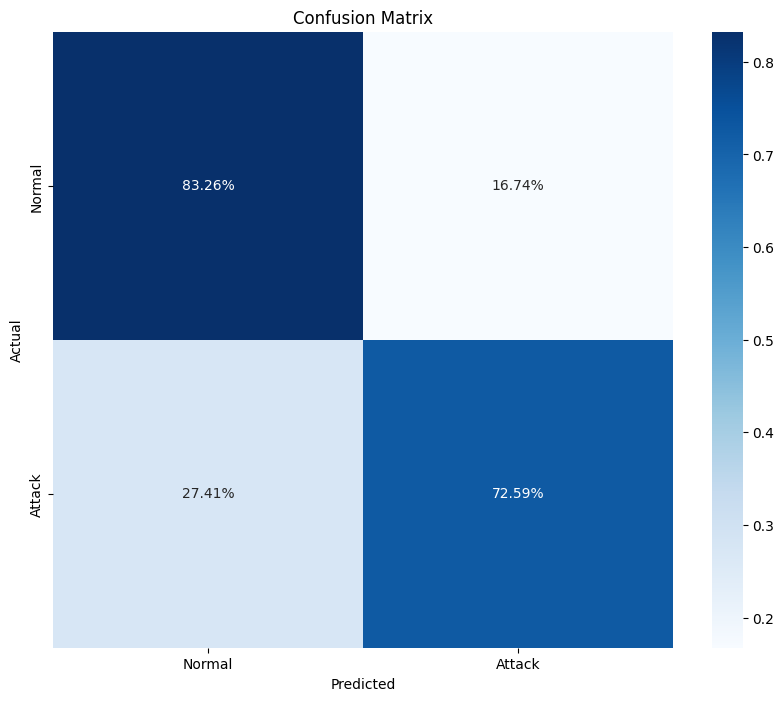

In [18]:
model.eval()
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

all_preds = []
all_labels = []

with torch.no_grad():
    for data_batch in test_loader:
        x_batch = data_batch["given"].to(device)
        y_batch = data_batch["label"].to(device)
        outputs = model(x_batch)
        y_batch_indices = torch.argmax(y_batch, dim=1)
        predicted = torch.argmax(outputs, dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch_indices.cpu().numpy())

all_preds = np.array(all_preds).reshape(-1)
all_labels = np.array(all_labels).reshape(-1)

accuracy = (all_preds == all_labels).mean()
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f'Test Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}\n')

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Creation of a wrapper of the model that compute the probs of each class

In [19]:
def model_probs(model):

    def f(data):    
        model.eval()
        with torch.no_grad():
            #check if the batch size is 1
            if len(data.shape) == 2:
                data = data.unsqueeze(0)
            data = data.to(device)  # data shape: [batch_size, ...]
            outputs = model(data)   # outputs shape: [batch_size, num_classes]
            probabilities = torch.softmax(outputs, dim=1)
            return probabilities
    return f

model_wrapper = model_probs(model)

## 2 - ShaTS xAI Component

#### Configuration

In [20]:
!cd ..

In [21]:
import os
import sys
# sys.path.append(os.path.abspath("../src"))
sys.path.append("../")
print(sys.path)

import app.services.explainers.shats_impl as shats
# import shats
# from shats.grouping import TimeGroupingStrategy, MultifeaturesGroupingStrategy, FeaturesGroupingStrategy

['/home/prims/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python311.zip', '/home/prims/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11', '/home/prims/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/lib-dynload', '', '/home/prims/Projects/DLR_werkstudent/final_work/fastapi_feature_attribution_local_time_seriesfinal_work/xai_ts_service/.venv/lib/python3.11/site-packages', '/tmp/tmp0upvy1v7', '../']


#### Creation of the background dataset and selection of the windows that will be explained 

In [22]:
random_samples = random.sample(range(len(trainDataset)), 100)
support = [trainDataset[idx]['given'] for idx in random_samples]

begin = 798 #begining instant to be explained
end = begin + 100 #end instant to be explained
test = [testDataset[idx]['given'] for idx in range(begin, end)]


### 2.1 - ShaTS Temporal Strategy

In this strategy, all feature values corresponding to each individual time instant within a window are grouped together, allowing ShaTS to reveal which specific points in time exert the greatest influence on the model’s anomaly predictions. This grouping is particularly useful for highlighting critical moments—such as the onset or end of an attack—within a time window.

Below is a brief example of how to employ the temporal grouping strategy using ShaTS

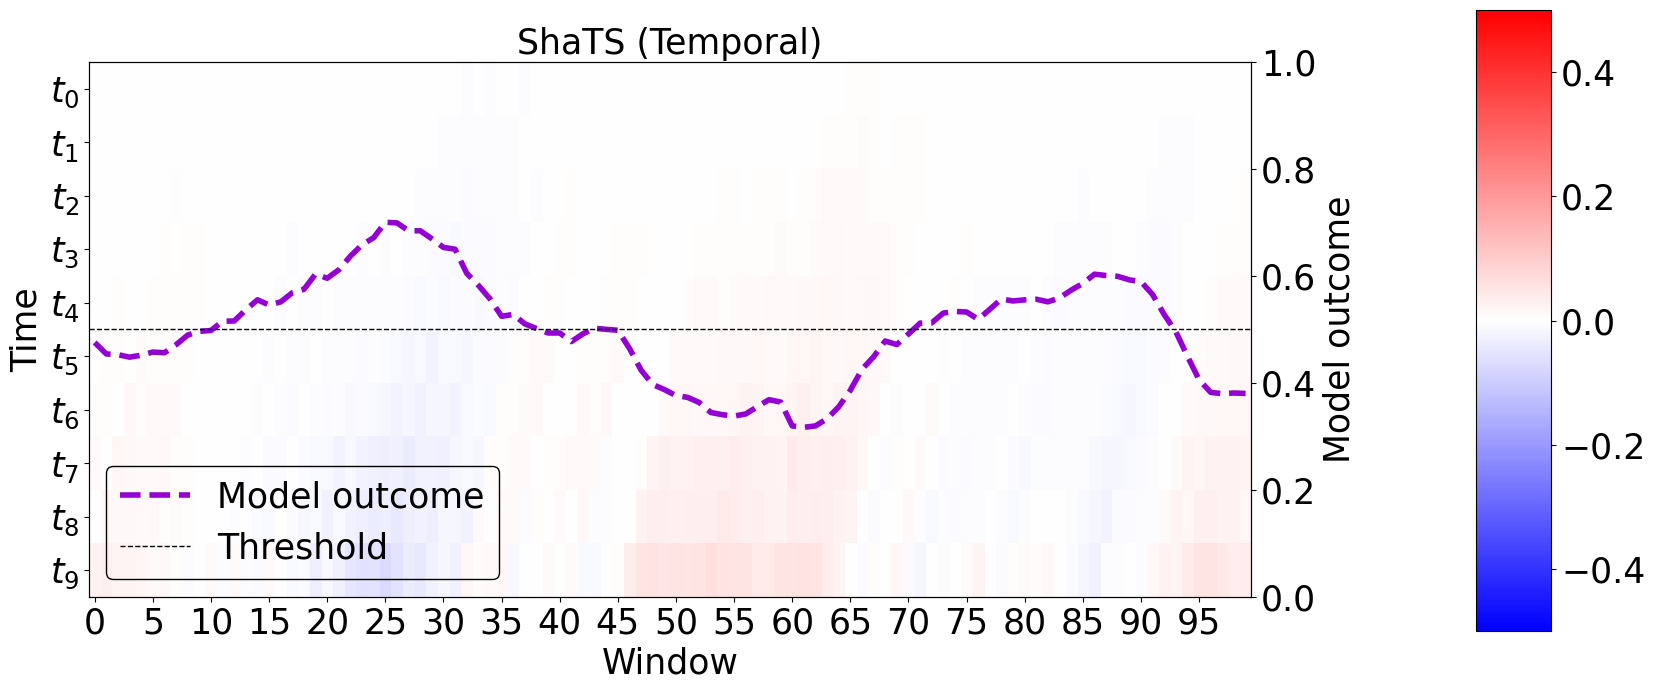

In [23]:
shapley_class = shats.FastShaTS(model_wrapper, 
                               support_dataset=support ,
                               grouping_strategy= shats.TimeGroupingStrategy(names=["$t_0$", "$t_1$", "$t_2$", "$t_3$", "$t_4$", "$t_5$", "$t_6$", "$t_7$", "$t_8$", "$t_9$"])
                               )

shapley_values = shapley_class.compute(test)
shapley_class.plot(shapley_values, test, class_to_explain=0)

In [24]:
shapley_values.shape

torch.Size([100, 10, 2])

In [25]:
test.count

<function list.count(value, /)>

### 2.2 - ShaTS Feature Strategy

In this strategy, individual features are grouped across time, allowing each feature's contribution to be evaluated independently within a time window. This approach enables the identification of which specific features are most influential in driving the model’s predictions.

In [ ]:
shapley_class = shats.FastShaTS(model_wrapper, 
                               support_dataset=support ,
                               grouping_strategy= shats.FeaturesGroupingStrategy(names=variable_names),
                               )

shapley_values = shapley_class.compute(test)
shapley_class.plot(shapley_values, test, class_to_explain=1)

### 2.3 - ShaTS MultiFeature Strategy

The feature strategy is effective at highlighting the importance of individual features within a time window. However, when several features essentially represent the same underlying aspect, a multi-feature strategy proves more beneficial. This approach aggregates related features into one group, providing a clearer and more consolidated interpretation of their collective influence.

Two illustrative examples are provided:
- **Index-Based Grouping:** In this example, features are grouped into four clusters based on their indices. Although this grouping is only illustrative, it demonstrates how aggregating related features can yield a unified explanation.
- **Type-Based Grouping:** In this case, features are separated into two groups—one for continuous variables and another for categorical variables. This strategy helps to determine whether one group (particularly the categorical variables, which are known to have limited influence due to the dataset's construction) contributes significantly to the model’s predictions.

By capturing the aggregate effect of related features, ShaTS delivers more coherent and actionable insights compared to treating each feature independently.

In [ ]:
index_grouping = [[],[],[],[]]   

for i in range(len(all_feature_names)):
    index_grouping[i % 4].append(i)
print(f"Process: {index_grouping}")

type_grouping = [[],[]]   

for i in range(len(all_feature_names)):
    if i < len(continuous_columns):
        type_grouping[0].append(i)
    else:
        type_grouping[1].append(i)

print(f"Process2: {type_grouping}")

Process: [[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68], [1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69], [2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66], [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67]]
Process2: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]]


Processing item 100/100 (100.00%)

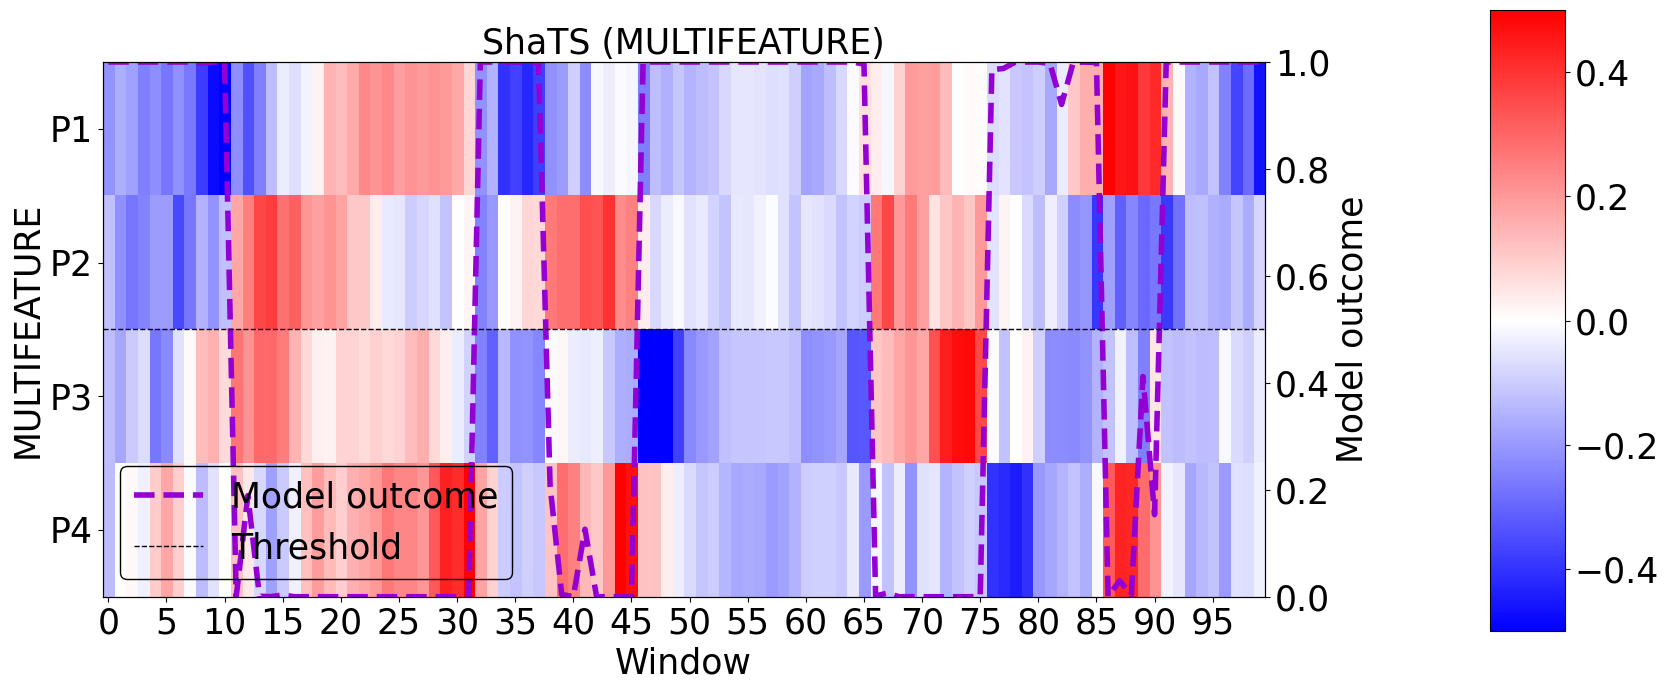

In [ ]:
shapley_class = shats.ApproShaTS(model_wrapper = model_wrapper,
                               support_dataset=support ,
                               grouping_strategy= shats.MultifeaturesGroupingStrategy(custom_groups=index_grouping, names= ["P1", "P2", "P3", "P4"]),
                               )

shapley_values = shapley_class.compute(test)

shapley_class.plot(shapley_values, test, class_to_explain=1)

/home/manuelfrancop/Escritorio/TS-SHAP/gitRefactorPaula/TSG-SHAP/src/shats/utils.py:184: RuntimeWarning: divide by zero encountered in scalar divide
  m = (total_desired_subsets - intercept) / slope


Processing item 100/100 (100.00%)

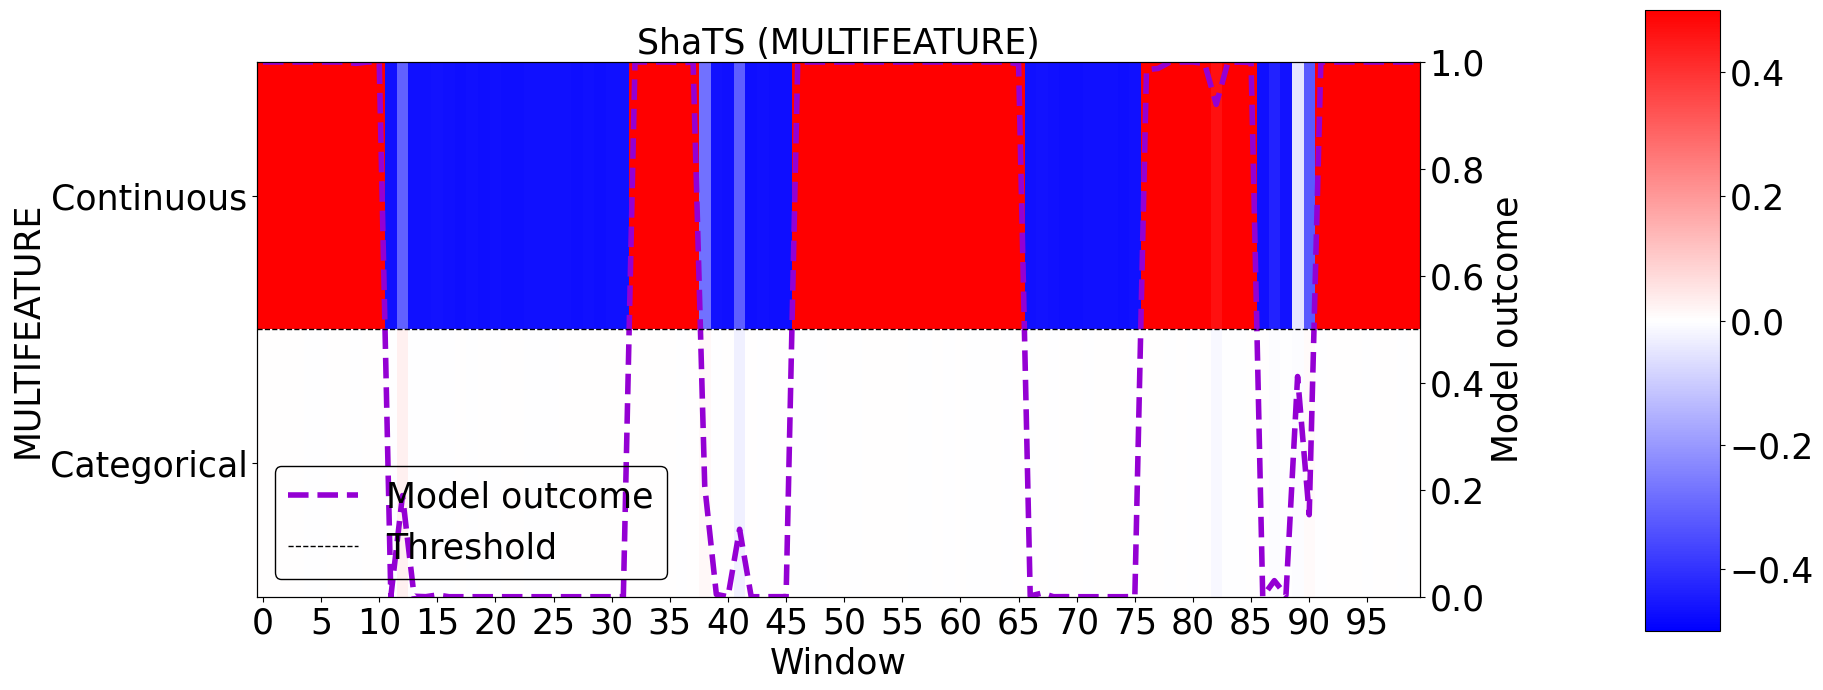

In [ ]:
shapley_class = shats.FastShaTS(model_wrapper = model_wrapper,
                               support_dataset=support ,
                               grouping_strategy= shats.MultifeaturesGroupingStrategy(custom_groups=type_grouping, names= ["Continuous", "Categorical"]),
                               )

shapley_values = shapley_class.compute(test)

shapley_class.plot(shapley_values, test, class_to_explain=1)

In [ ]:
# model = MyTrainedModel()
# support = [...]  

shapley_class = shats.FastShaTS(model_wrapper, 
    support_dataset=support,
    grouping_strategy= shats.FeaturesGroupingStrategy(names=variable_names)
)